In [7]:
import setup

import jax.numpy as jnp
import pandas as pd

import uuid

import src.utils.pandas_utils as pdu
from src.utils.misc import generate_interval_requirements

from src.shift_requirements import (
    ShiftRequirements,
    GradientDescentParams,
    ShiftBlueprint,
)

from src.entities.data_classes import Shift

#### **Defining Shift Blueprints**

- **Shift list**: In order to initialize a the ShiftRequirements class we must provide a list of Shift Blueprints. They must have different names.

- **Custom coverage**: Advanced feature. Allows editing how much coverage each shift provides to the total coverage.

In [2]:
# Defining a series of shift blueprints, in this example all shifts starting an ODD hours
# and that with a duration 9 INTERVALS

db_shifts = [
    Shift(id="A", skill="basic", start_time=1, duration=9),
    Shift(id="B", skill="basic", start_time=3, duration=9),
    Shift(id="C", skill="basic", start_time=5, duration=9),
    Shift(id="D", skill="basic", start_time=7, duration=9),
    Shift(id="E", skill="basic", start_time=9, duration=9),
    Shift(id="F", skill="basic", start_time=11, duration=9),
    Shift(id="G", skill="basic", start_time=13, duration=9),
    Shift(id="H", skill="basic", start_time=15, duration=9),
    Shift(id="I", skill="basic", start_time=17, duration=9),
    Shift(id="J", skill="basic", start_time=19, duration=9),
    Shift(id="K", skill="basic", start_time=21, duration=9),
    Shift(id="L", skill="basic", start_time=23, duration=9),
]


shifts = [
    ShiftBlueprint(
        shift,
        daily_intervals=24,  # dividing start times in intervals of 24 hours
        coverage=jnp.ones(9) * 0.95,  # Shifts provide 95% of coverage instead of 100%
    )
    for shift in db_shifts
]

#### **Generating Shift Requirements**

- **Initialize ShiftRequirements**: Create an instance of the class <code>ShiftRequirements</code>.

- **Adjust Params**: We can change some og the algorythm parameters by loading a valid Params class instance using the <code>set_params</code> method.

- **Generate**: Running the <code>generate</code> method returns the weights, and evolution of said weights on each of the algorythm sub-processes. These outputs are also stored, along with copies of all parameters, inputs and class state into the instance's <code>last_generated</code> attribute.

In [3]:
# Initialize Shift Requirements
num_weeks = 4

shift_reqs = ShiftRequirements(shifts=shifts, days=7 * num_weeks, daily_intervals=24)

shift_reqs.set_params(
    GradientDescentParams(learning_rate=1, num_iterations=15000, snapshot_length=150),
)

ir = generate_interval_requirements(weeks=num_weeks)
lb = shift_reqs.generate_lower_bounds(
    {
        "S01": [1, 1, 1, 1, 1, 0, 0],  # Weekly pattern, minimum 1 shift Mon to Fri
        "S11": [3],  # Minimum 1 shift every 2nd day
    }
)

# Generate Requirements
weights, gd_evol, sr_evol = shift_reqs.generate(
    interval_reqs=ir,
    lower_bounds=lb,
)

--- GRADIENT DESCENT ---
Iteration 0: Error = 82.46395874023438
Iteration 150: Error = 0.381763756275177
Iteration 300: Error = 0.3565709590911865
Iteration 450: Error = 0.348934531211853
Iteration 600: Error = 0.3449734151363373
Iteration 750: Error = 0.3422347903251648
Iteration 900: Error = 0.34016966819763184
Iteration 1050: Error = 0.33849436044692993
Iteration 1200: Error = 0.33707958459854126
Iteration 1350: Error = 0.3358536958694458
Iteration 1500: Error = 0.33476579189300537
Iteration 1650: Error = 0.3338053822517395
Iteration 1800: Error = 0.33296412229537964
Iteration 1950: Error = 0.3322368562221527
Iteration 2100: Error = 0.3316119313240051
Iteration 2250: Error = 0.3310651183128357
Iteration 2400: Error = 0.3305888772010803
Iteration 2550: Error = 0.33017173409461975
Iteration 2700: Error = 0.32980597019195557
Iteration 2850: Error = 0.32949304580688477
Iteration 3000: Error = 0.3292199969291687
Iteration 3150: Error = 0.32897698879241943
Iteration 3300: Error = 0.328758

#### Exploring Results:

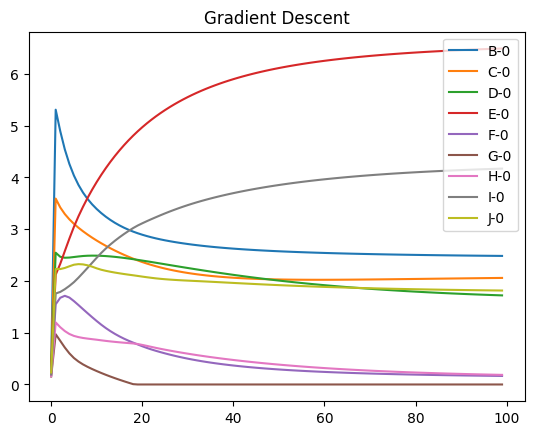

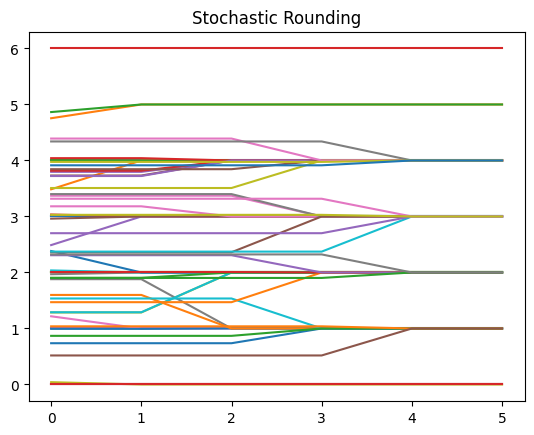

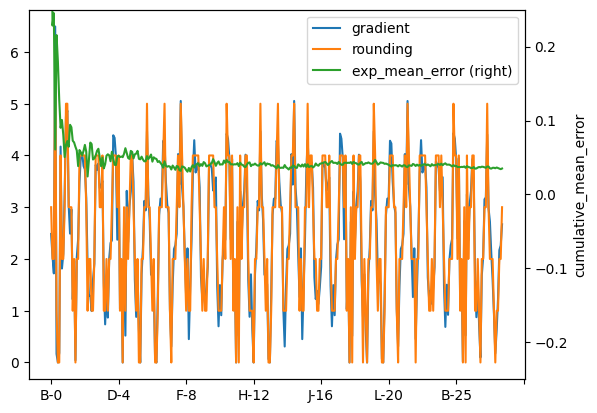

In [8]:
# Evolution DataFrames
gradient_evol_df = pdu.evolution_df("gd_evolution", shift_reqs)

stoch_round_evol_df = pdu.evolution_df("sr_evolution", shift_reqs)

# Visualize Gradient Evolution
gradient_evol_df.iloc[:, 1:10].plot(title="Gradient Descent")

# Visualize Gradient Evolution
stoch_round_evol_df.iloc[:6, 1 : 12 * 5].plot(legend=False, title="Stochastic Rounding")

# Last Step Comparison
last_steps_df = pd.concat(
    (
        gradient_evol_df.iloc[-1].rename("gradient"),
        stoch_round_evol_df.iloc[-1].rename("rounding"),
    ),
    axis=1,
)[1:]
last_steps_df.plot()
last_steps_df["exp_mean_error"] = (
    (last_steps_df.rounding - last_steps_df.gradient).expanding().mean()
)
last_steps_df.exp_mean_error.plot(
    secondary_y=True, legend=True, ylabel="cumulative_mean_error", ylim=(-0.25, 0.25)
)

None

<Axes: >

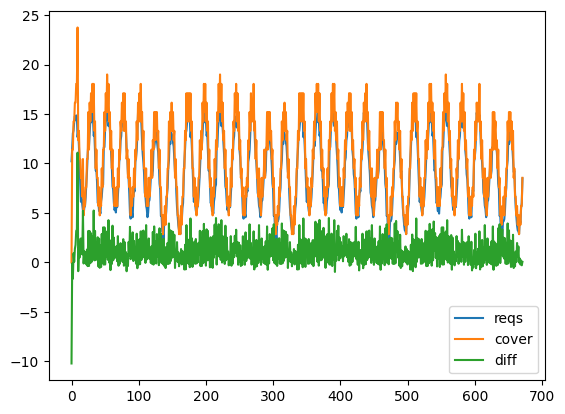

In [9]:
pdu.shift_reqs_coverage_df(shift_reqs).plot()

In [10]:
pdu.shift_reqs_results_df(shift_reqs).pivot(
    columns="shift_name", index="day_index", values="req"
)

shift_name,A,B,C,D,E,F,G,H,I,J,K,L
day_index,,,,,,,,,,,,
0,12.0,3.0,2.0,2.0,6.0,1.0,0.0,0.0,4.0,2.0,2.0,3.0
1,5.0,5.0,3.0,3.0,3.0,1.0,2.0,0.0,2.0,2.0,4.0,4.0
2,4.0,4.0,4.0,3.0,1.0,2.0,2.0,1.0,1.0,2.0,4.0,4.0
3,4.0,3.0,3.0,4.0,1.0,1.0,2.0,1.0,2.0,2.0,3.0,4.0
4,4.0,4.0,3.0,4.0,1.0,2.0,0.0,3.0,1.0,3.0,2.0,3.0
5,4.0,4.0,3.0,2.0,1.0,2.0,0.0,0.0,2.0,2.0,3.0,3.0
6,5.0,3.0,3.0,2.0,1.0,2.0,0.0,0.0,1.0,3.0,3.0,3.0
7,4.0,5.0,3.0,3.0,3.0,1.0,0.0,2.0,2.0,2.0,3.0,4.0
8,3.0,5.0,4.0,3.0,2.0,1.0,2.0,1.0,1.0,3.0,4.0,4.0


In [12]:
pdu.evolution_df(type="sr_evolution", instance=shift_reqs)

,A-0,B-0,C-0,D-0,E-0,F-0,G-0,H-0,I-0,J-0,...,C-27,D-27,E-27,F-27,G-27,H-27,I-27,J-27,K-27,L-27
0,12.0,3.0,2.0,2.0,6.0,1.0,0.0,0.0,4.0,2.0,...,2.725097,2.116755,1.600771,0.943031,0.1764,0.624299,1.217165,2.171156,2.26106,2.669778
1,12.0,3.0,2.0,2.0,6.0,1.0,0.0,0.0,4.0,2.0,...,2.725097,2.116755,1.600771,0.943031,0.1764,0.624299,1.217165,2.171156,2.26106,2.669778
2,12.0,3.0,2.0,2.0,6.0,1.0,0.0,0.0,4.0,2.0,...,2.725097,2.116755,1.600771,0.943031,0.1764,0.624299,1.217165,2.171156,2.26106,2.669778
3,12.0,3.0,2.0,2.0,6.0,1.0,0.0,0.0,4.0,2.0,...,2.725097,2.116755,1.600771,0.943031,0.1764,0.624299,1.217165,2.171156,2.26106,2.669778
4,12.0,3.0,2.0,2.0,6.0,1.0,0.0,0.0,4.0,2.0,...,2.725097,2.116755,1.600771,0.943031,0.1764,0.624299,1.217165,2.171156,2.26106,2.669778
5,12.0,3.0,2.0,2.0,6.0,1.0,0.0,0.0,4.0,2.0,...,2.725097,2.116755,1.600771,0.943031,0.1764,0.624299,1.217165,2.171156,2.26106,2.669778
6,12.0,3.0,2.0,2.0,6.0,1.0,0.0,0.0,4.0,2.0,...,2.725097,2.116755,1.600771,0.943031,0.1764,0.624299,1.217165,2.171156,2.26106,2.669778
7,12.0,3.0,2.0,2.0,6.0,1.0,0.0,0.0,4.0,2.0,...,2.725097,2.116755,1.600771,0.943031,0.1764,0.624299,1.217165,2.171156,2.26106,2.669778
8,12.0,3.0,2.0,2.0,6.0,1.0,0.0,0.0,4.0,2.0,...,2.725097,2.116755,1.600771,0.943031,0.1764,0.624299,1.217165,2.171156,2.26106,2.669778
9,12.0,3.0,2.0,2.0,6.0,1.0,0.0,0.0,4.0,2.0,...,2.725097,2.116755,1.600771,0.943031,0.1764,0.624299,1.217165,2.171156,2.26106,2.669778


In [ ]:
from scheduling.agent import Agent, WeeklyPattern
import faker

all_patterns = [
    [True, True, True, True, True, False, False],
    [True, True, True, True, False, True, False],
    [True, True, True, True, False, False, True],
    [True, True, True, False, True, True, False],
    [True, True, True, False, True, False, True],
    [True, True, True, False, False, True, True],
    [True, True, False, True, True, True, False],
    [True, True, False, True, True, False, True],
    [True, True, False, True, False, True, True],
    [True, True, False, False, True, True, True],
    [True, False, True, True, True, True, False],
    [True, False, True, True, True, False, True],
    [True, False, True, True, False, True, True],
    [True, False, True, False, True, True, True],
    [True, False, False, True, True, True, True],
    [False, True, True, True, True, True, False],
    [False, True, True, True, True, False, True],
    [False, True, True, True, False, True, True],
    [False, True, True, False, True, True, True],
    [False, True, False, True, True, True, True],
    [False, False, True, True, True, True, True],
]


patterns = [WeeklyPattern(id="123", pattern=p) for p in all_patterns]

from scheduling.agent import Constraints, Agent

a = Agent(id=faker.Faker().email(), skills=["chat"], constraints=Constraints())

ModuleNotFoundError: No module named 'scheduling'

In [ ]:
a.id

'spetersen@example.net'